In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

spark = SparkSession.builder.appName("weather forecasting").getOrCreate()

22/02/18 14:46:22 WARN Utils: Your hostname, Subh-Ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.29.54 instead (on interface wlp4s0)
22/02/18 14:46:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/18 14:46:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = spark.read.csv("weatherHistory.csv",inferSchema= True, header= True)
data.show(2)

+--------------------+-------------+-----------+-----------------+------------------------+--------+-----------------+----------------------+------------------+----------+--------------------+--------------------+
|      Formatted Date|      Summary|Precip Type|  Temperature (C)|Apparent Temperature (C)|Humidity|Wind Speed (km/h)|Wind Bearing (degrees)|   Visibility (km)|Loud Cover|Pressure (millibars)|       Daily Summary|
+--------------------+-------------+-----------+-----------------+------------------------+--------+-----------------+----------------------+------------------+----------+--------------------+--------------------+
|2006-04-01 00:00:...|Partly Cloudy|       rain|9.472222222222221|      7.3888888888888875|    0.89|          14.1197|                 251.0|15.826300000000002|       0.0|             1015.13|Partly cloudy thr...|
|2006-04-01 01:00:...|Partly Cloudy|       rain|9.355555555555558|       7.227777777777776|    0.86|          14.2646|                 259.0|15.

In [4]:
#first step is to check whether it has any null values
#since pyspark data frame doesn't have that feature so we have no problem otherwise we would have dropped 
# the null values or processed further.

pd_data = data.toPandas()
pd_data.isnull().any()        #to check the null values in any column if it exist.



Formatted Date              False
Summary                     False
Precip Type                 False
Temperature (C)             False
Apparent Temperature (C)    False
Humidity                    False
Wind Speed (km/h)           False
Wind Bearing (degrees)      False
Visibility (km)             False
Loud Cover                  False
Pressure (millibars)        False
Daily Summary               False
dtype: bool

In [5]:
#this is checking all the categorical data and the count and all details about it
#we can import StringIndexer to change the string to integer or we can do it manually 

pd_data.describe(include=['O'])

,Formatted Date,Summary,Precip Type,Daily Summary
count,96453,96453,96453,96453
unique,96429,27,3,214
top,2010-08-02 00:00:00.000 +0200,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,2,31733,85224,20085


In [6]:
pd_data.corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,NaN,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,NaN,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,NaN,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,NaN,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,NaN,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,NaN,0.059818
Loud Cover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,NaN,1.000000


From the above table we can see that there is a high positive correlation between temperature and apparent temperature
and -ve correlation between temperature and humidity. Also temperature has slight positive correlation with visibility.

In [10]:
pd_data_ref = pd_data[['Temperature (C)','Apparent Temperature (C)','Humidity']]
#extracting required fields in a data frame
pd_data_ref.corr()

,Temperature (C),Apparent Temperature (C),Humidity
Temperature (C),1.000000,0.992629,-0.632255
Apparent Temperature (C),0.992629,1.000000,-0.602571
Humidity,-0.632255,-0.602571,1.000000


<AxesSubplot:xlabel='Temperature (C)', ylabel='Humidity'>

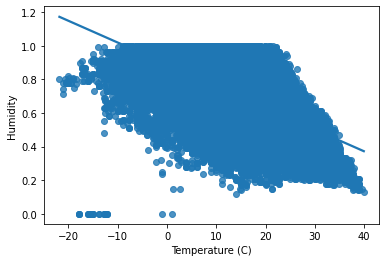

In [11]:
#to check outliers we plot graphs
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=pd_data_ref["Temperature (C)"], y=pd_data_ref["Humidity"])

/home/subh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


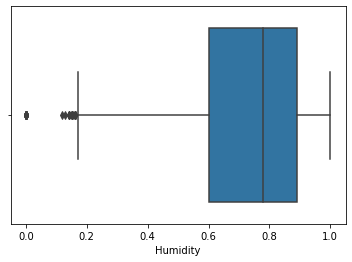

In [14]:
sns.boxplot(pd_data_ref['Humidity'])
plt.show()

we see that there are some 0 valued humidity levels which are practically impossible to find in earth. so we can drop them as they will hamper the statistics.

<AxesSubplot:xlabel='Temperature (C)', ylabel='Apparent Temperature (C)'>

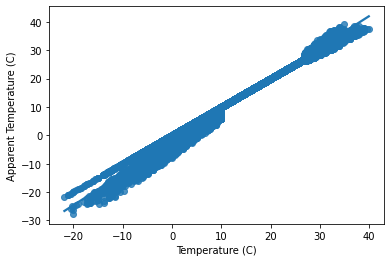

In [12]:
sns.regplot(x=pd_data_ref["Temperature (C)"], y=pd_data_ref["Apparent Temperature (C)"])

[0.14, 0.14, 0.14, 0.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12, 0.14]


<AxesSubplot:xlabel='Humidity'>

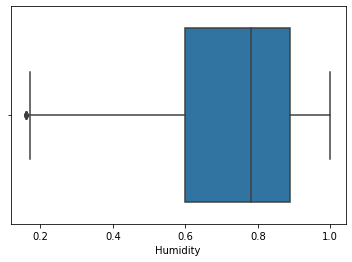

In [19]:
#there are practically many ways to detect and remove outliers. or work on them. visualisation tools like boxplot tells
#us about the outliers. Z score and IQR scores also tells us about the outliers. 
#we are using to remove outliers based on z score for humidity.

outliers=[]
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers
outlier_data = detect_outlier(pd_data_ref["Humidity"])

print(outlier_data)
# now we drop any value which is less than 0.15 humidity as seen from the printed part.

clean_pd_data = pd_data_ref[pd_data_ref['Humidity']>0.15]      #creating a clean data without outliers

sns.boxplot(clean_pd_data["Humidity"])


In [23]:
#now we create vector Assembler object by taking apparent temperature and humidity as feature and temperature as label 

feature_cols = ['Humidity','Apparent Temperature (C)']     #list of columns we need to create the feature

from pyspark.ml.feature import VectorAssembler
vect_assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")

In [29]:
#Utilize Assembler created above in order to add the feature column
spark_df = spark.createDataFrame(clean_pd_data)        #converting to pyspark df as we will work with mllib

data_w_features = vect_assembler.transform(spark_df)
print(type(data_w_features))
data_w_features.show(2)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------------+------------------------+--------+--------------------+
|  Temperature (C)|Apparent Temperature (C)|Humidity|            features|
+-----------------+------------------------+--------+--------------------+
|9.472222222222221|      7.3888888888888875|    0.89|[0.89,7.388888888...|
|9.355555555555558|       7.227777777777776|    0.86|[0.86,7.227777777...|
+-----------------+------------------------+--------+--------------------+
only showing top 2 rows



In [33]:
finalised_df = data_w_features.select('features','Temperature (C)')

#train dataset
train_dataset, test_dataset = finalised_df.randomSplit([0.8, 0.2])    #80-20 percent
train_dataset.describe().show()

+-------+-------------------+
|summary|    Temperature (C)|
+-------+-------------------+
|  count|              77071|
|   mean|  11.90618744044094|
| stddev|  9.545299878773918|
|    min|-21.822222222222223|
|    max|  38.86666666666666|
+-------+-------------------+



In [35]:
test_dataset.describe().show()

+-------+------------------+
|summary|   Temperature (C)|
+-------+------------------+
|  count|             19344|
|   mean|12.054368566767755|
| stddev|  9.52640280058617|
|    min|-21.11111111111111|
|    max|38.983333333333334|
+-------+------------------+



In [36]:
from pyspark.ml.regression import LinearRegression

LinReg = LinearRegression(featuresCol="features", labelCol="Temperature (C)")

#Train the model on the training using fit() method.
model = LinReg.fit(train_dataset)

pred = model.evaluate(test_dataset)

pred.predictions.show(20)

22/02/18 16:21:16 WARN Instrumentation: [610f454e] regParam is zero, which might cause numerical instability and overfitting.
22/02/18 16:21:16 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/02/18 16:21:16 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/02/18 16:21:16 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------------------+------------------+------------------+
|            features|   Temperature (C)|        prediction|
+--------------------+------------------+------------------+
|[0.27,26.36111111...|27.083333333333332|26.451815791341627|
|[0.28,26.86111111...| 27.77777777777778| 26.85373272435495|
|[0.29,23.04444444...|23.044444444444448|23.557067819556597|
|[0.29,26.01666666...|26.016666666666666|26.103710397715215|
|[0.29,26.51666666...|27.199999999999996|26.532117560396106|
|[0.29,29.82222222...|31.161111111111115|29.364364913675324|
|[0.29,31.59999999...| 32.75555555555555| 30.88759038098515|
|[0.3,22.272222222...|22.272222222222226|22.868926527526323|
|[0.3,31.644444444...| 32.68333333333333|30.899180788000326|
|[0.31,17.23888888...| 17.23888888888889|  18.5298041935378|
|[0.32,21.14444444...|21.144444444444446|21.849649912366516|
|[0.32,25.04444444...| 25.04444444444444|25.191225781277453|
|[0.32,25.90000000...|25.900000000000002| 25.92427803742031|
|[0.32,26.67222222...| 2

/home/subh/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [40]:
coefficient = model.coefficients
print ("The coefficient of the model is : %a" %coefficient)

intercept = model.intercept
print ("The Intercept of the model is : %f" %intercept)

The coefficient of the model is : DenseVector([-2.649, 0.8568])
The Intercept of the model is : 4.580474


In [41]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluation = RegressionEvaluator(labelCol="Temperature (C)", predictionCol="prediction")

# Root Mean Square Error
rmse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = evaluation.evaluate(pred.predictions, {evaluation.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 1.074
MSE: 1.153
MAE: 0.814
r2: 0.987
